<a href="https://colab.research.google.com/github/yacanom/MAIA/blob/main/MLNS_Modelado_de_t%C3%B3picos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Importación de paquetes

In [16]:
import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

%matplotlib inline


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Cargue datos

In [2]:
# Cargue de datos desde Kaggle usando
!ls -lha kaggle.json
!pip install -q kaggle # installing the kaggle package
!mkdir -p ~/.kaggle # creating .kaggle folder where the key should be placed
!cp kaggle.json ~/.kaggle/ # move the key to the folder
!pwd # checking the present working directory

!chmod 600 ~/.kaggle/kaggle.json

-rw-r--r-- 1 root root 65 Aug 25 01:45 kaggle.json
/content
ref                                                              title                                                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------  --------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
yashdevladdha/uber-ride-analytics-dashboard                      Uber Data Analytics Dashboard                         17324552  2025-08-08 11:13:42.920000          18264        417  1.0              
mdsultanulislamovi/student-stress-monitoring-datasets            Student Stress Monitoring Datasets                       24336  2025-07-24 16:30:01.617000           9944        168  1.0              
rohitgrewal/airlines-flights-data                                Airlines Flights Data                                  2440299  2025-07

In [4]:
!kaggle datasets download -d kevinmorgado/spanish-news-classification

Dataset URL: https://www.kaggle.com/datasets/kevinmorgado/spanish-news-classification
License(s): CC0-1.0
  0% 0.00/1.38M [00:00<?, ?B/s]
100% 1.38M/1.38M [00:00<00:00, 956MB/s]


In [5]:
!unzip /content/spanish-news-classification

Archive:  /content/spanish-news-classification.zip
  inflating: df_total.csv            


# **Preparación de los Datos**

In [9]:
datafile = '/content/df_total.csv'
df = pd.read_csv(datafile)

df.head()

,url,news,Type
0,https://www.larepublica.co/redirect/post/3201905,Durante el foro La banca articulador empresari...,Otra
1,https://www.larepublica.co/redirect/post/3210288,El regulador de valores de China dijo el domin...,Regulaciones
2,https://www.larepublica.co/redirect/post/3240676,En una industria históricamente masculina como...,Alianzas
3,https://www.larepublica.co/redirect/post/3342889,Con el dato de marzo el IPC interanual encaden...,Macroeconomia
4,https://www.larepublica.co/redirect/post/3427208,Ayer en Cartagena se dio inicio a la versión n...,Otra


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1217 entries, 0 to 1216
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   url     1217 non-null   object
 1   news    1217 non-null   object
 2   Type    1217 non-null   object
dtypes: object(3)
memory usage: 28.7+ KB


In [13]:
data = df[['news']]
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1217 entries, 0 to 1216
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   news    1217 non-null   object
dtypes: object(1)
memory usage: 9.6+ KB
None


,news
0,Durante el foro La banca articulador empresari...
1,El regulador de valores de China dijo el domin...
2,En una industria históricamente masculina como...
3,Con el dato de marzo el IPC interanual encaden...
4,Ayer en Cartagena se dio inicio a la versión n...


El único paso de preprocesamiento necesario en nuestro caso es la construcción de características, en la que tomamos el texto de las noticias y los representamos en algún espacio de características manejable. En la práctica, esto significa simplemente convertir cada cadena en un vector numérico.

In [17]:
# Vectorization with stopwords in Spanish (assuming Spanish text)
spanish_stop_words = stopwords.words('spanish')

vectorizer = CountVectorizer(stop_words=spanish_stop_words, max_features=40000)
document_term_matrix = vectorizer.fit_transform(data['news'])

# Obtain the vocabulary using the recommended method
vocabulary = vectorizer.get_feature_names_out()

# Ejemplo: Obtener el vector de un texto específico
text_to_vectorize = data['news'].iloc[0]  # Obtener el primer texto
text_vector = vectorizer.transform([text_to_vectorize]).toarray()

print('Vector del texto:', text_vector)
print('Vocabulario:', vocabulary)

Vector del texto: [[0 0 0 ... 0 0 0]]
Vocabulario: ['00' '000' '000a' ... 'úrsula' 'útil' 'útiles']


## **Modelamiento**

### Latent Semantic Analysis

In [19]:
n_topics = 4

lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(document_term_matrix)

Si tomamos el argmáx de cada queja en esta matriz de temas, obtendremos los temas previstos para cada queja. A continuación, podemos clasificarlos en recuentos de cada tema.

In [20]:
# Define helper functions
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [21]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

Para caracterizarlas mejor, será útil encontrar las palabras más frecuentes en cada una de ellas.

In [24]:
# Define helper functions
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('utf-8').decode('utf-8'))
        top_words.append(" ".join(topic_words))
    return top_words

In [25]:
top_n_words_lsa = get_top_n_words(10, lsa_keys, document_term_matrix, vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

Topic 1:  bbva millones año empresas banco clientes colombia país crecimiento además
Topic 2:  inflación precios año alimentos ipc mes puntos tasa aumento variación
Topic 3:  energía agua electricidad eléctrica puede consumo solar renovables energías ser
Topic 4:  datos información clientes ciencia forma modelos learning empresas machine aprendizaje


Así, tenemos una lista de categorías temáticas previstas, en la que cada categoría se caracteriza por sus palabras más frecuentes. Las magnitudes relativas de cada una de estas categorías pueden visualizarse fácilmente mediante un gráfico de barras.

Topic Labels:
Topic 0: 
bbva millones año
Topic 1: 
inflación precios año
Topic 2: 
energía agua electricidad
Topic 3: 
datos información clientes


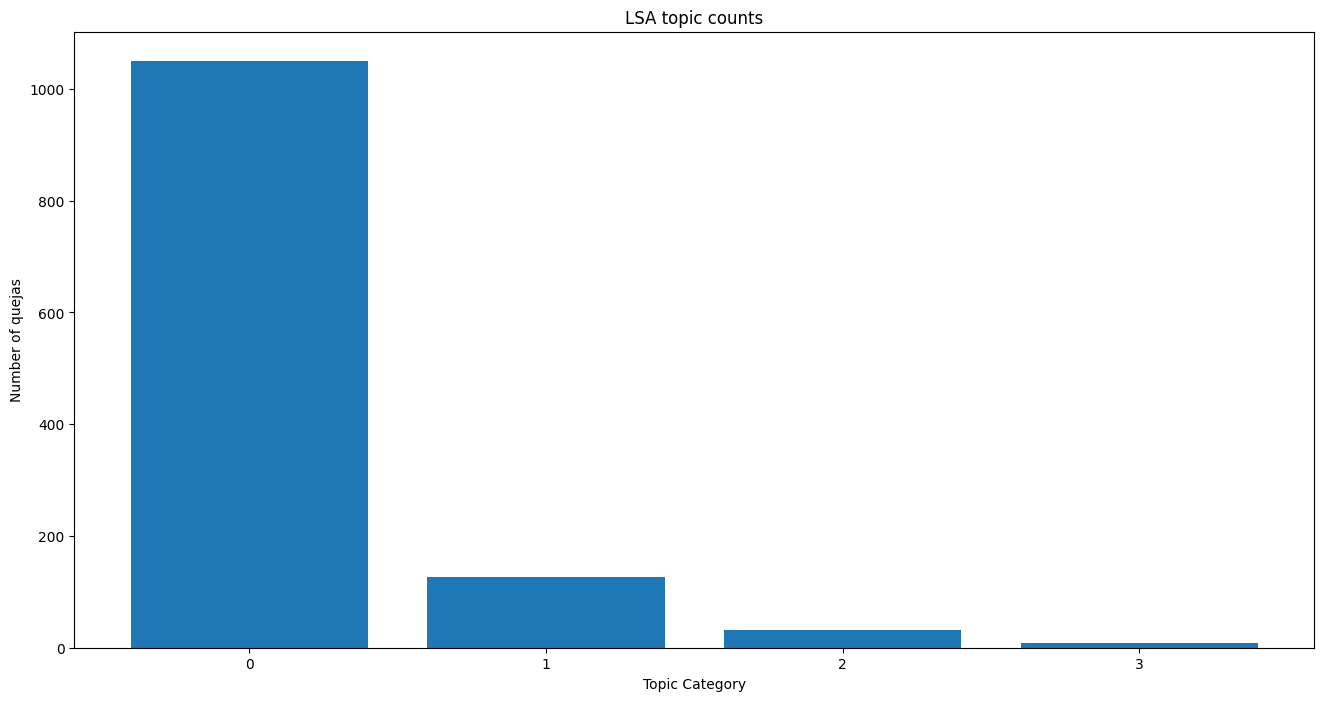

In [26]:
top_3_words = get_top_n_words(3, lsa_keys, document_term_matrix, vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]

print("Topic Labels:")
for i, category in enumerate(lsa_categories):
    label = "Topic {}: \n".format(i) + top_3_words[i]
    print(label)

# Create the bar chart with unformatted category labels
fig, ax = plt.subplots(figsize=(16, 8))
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
ax.set_xlabel('Topic Category');  # Change label to 'Topic Category'
ax.set_ylabel('Number of quejas');
ax.set_title('LSA topic counts');
plt.show()

In [27]:
tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=100,
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_matrix)

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1217 samples in 0.003s...
[t-SNE] Computed neighbors for 1217 samples in 0.052s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1217
[t-SNE] Computed conditional probabilities for sample 1217 / 1217
[t-SNE] Mean sigma: 0.918583
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.743050
[t-SNE] KL divergence after 2000 iterations: 0.619754


hora que hemos reducido estos vectores n_topics-dimensionales a representaciones bidimensionales, podemos trazar los clusters utilizando Bokeh. Antes de hacerlo, sin embargo, será útil derivar la ubicación del centroide de cada tema, a fin de contextualizar mejor nuestra visualización.

In [28]:
# Define helper functions
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(n_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])

        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

In [29]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_topics]

In [34]:
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label

top_3_words_lsa = get_top_n_words(3, lsa_keys, document_term_matrix, vectorizer)
lsa_mean_topic_vectors = get_mean_topic_vectors(lsa_keys, tsne_lsa_vectors)

plot = figure(title="t-SNE Clustering of {} LSA Topics".format(n_topics), width=700, height=700)
plot.scatter(x=tsne_lsa_vectors[:,0], y=tsne_lsa_vectors[:,1], color=colormap[lsa_keys])

# Define el color del texto de las etiquetas en negro
text_color = "black"

for t in range(n_topics):
  label = Label(x=lsa_mean_topic_vectors[t][0], y=lsa_mean_topic_vectors[t][1],
                text=top_3_words_lsa[t], text_color=text_color)
  plot.add_layout(label)

show(plot)

print("\nTopic Labels:")
for i, topic in enumerate(lsa_categories):
  label = "Topic {}:".format(i) + top_3_words_lsa[i]
  print(label)


Topic Labels:
Topic 0:bbva millones año
Topic 1:inflación precios año
Topic 2:energía agua electricidad
Topic 3:datos información clientes


### Latent Dirichilet Allocation
Ahora repetimos este proceso utilizando LDA en lugar de LSA. En cambio, LDA es un proceso probabilístico generativo, diseñado con el objetivo específico de descubrir la estructura temática latente en corpus de texto.

In [35]:
lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online',
                                          random_state=0, verbose=0)
lda_topic_matrix = lda_model.fit_transform(document_term_matrix)

In [36]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [37]:
top_n_words_lda = get_top_n_words(10, lda_keys, document_term_matrix, vectorizer)

for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i+1), top_n_words_lda[i])

Topic 1:  inflación precios año millones mayor crecimiento bbva alimentos aumento banco
Topic 2:  energía agua bbva puede sostenible si emisiones consumo además cada
Topic 3:  bbva empresas clientes banco colombia millones país través digital además
Topic 4:  cine mujeres avianca millones viva rutas momento colombia valadez aerolínea


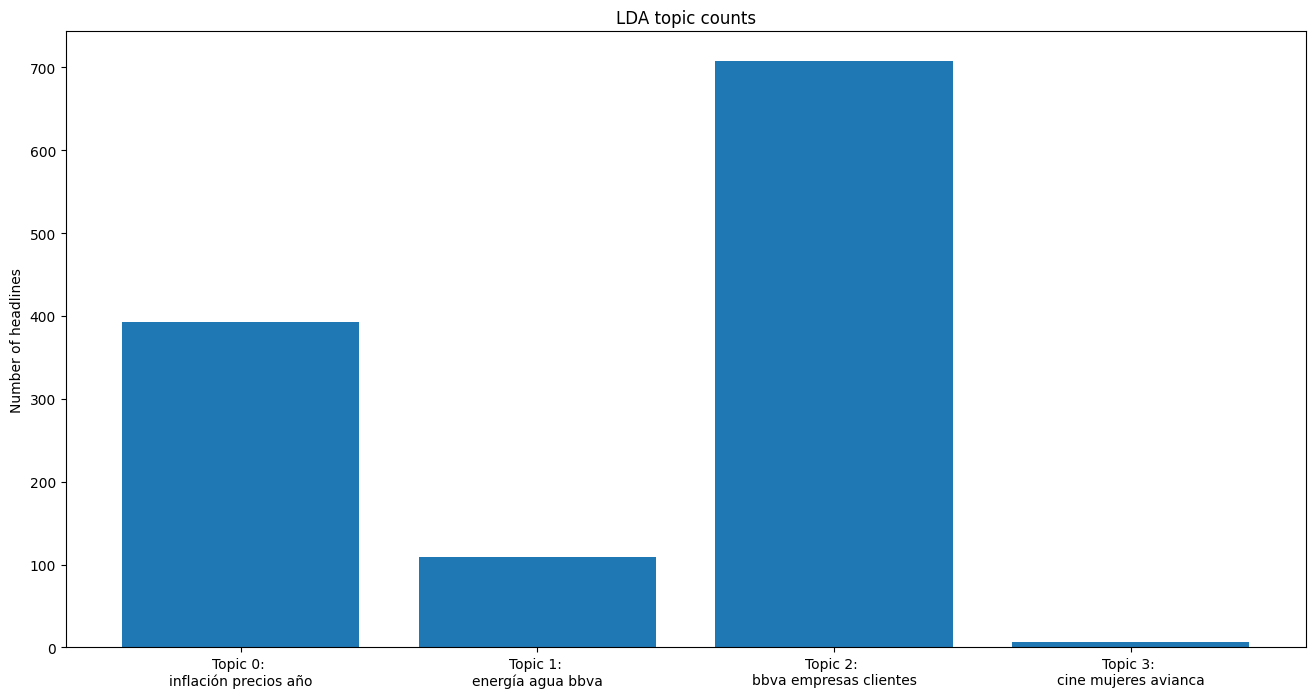

In [38]:
top_3_words = get_top_n_words(3, lda_keys, document_term_matrix, vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lda_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lda_categories, lda_counts);
ax.set_xticks(lda_categories);
ax.set_xticklabels(labels);
ax.set_title('LDA topic counts');
ax.set_ylabel('Number of headlines');

In [39]:
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100,
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix)

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1217 samples in 0.002s...
[t-SNE] Computed neighbors for 1217 samples in 0.029s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1217
[t-SNE] Computed conditional probabilities for sample 1217 / 1217
[t-SNE] Mean sigma: 0.000654
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.313885
[t-SNE] KL divergence after 2000 iterations: 0.164075


In [40]:
top_3_words_lda = get_top_n_words(3, lda_keys, document_term_matrix, vectorizer)
lda_mean_topic_vectors = get_mean_topic_vectors(lda_keys, tsne_lda_vectors)

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), width=700, height=700)
plot.scatter(x=tsne_lda_vectors[:,0], y=tsne_lda_vectors[:,1], color=colormap[lda_keys])

text_color = "black"

for t in range(n_topics):
  label = Label(x=lsa_mean_topic_vectors[t][0], y=lsa_mean_topic_vectors[t][1],
                text=top_3_words_lsa[t], text_color=text_color)
  plot.add_layout(label)

show(plot)

print("\n Topic Labels:")
for i, topic in enumerate(lda_categories):
  label = "Topic {}:".format(i) + top_3_words_lsa[i]
  print(label)


 Topic Labels:
Topic 0:bbva millones año
Topic 1:inflación precios año
Topic 2:energía agua electricidad
Topic 3:datos información clientes
